## What if some of the most polluting vehicles stop cicrulating?
This notebook explores the scenarios in which a certain share of vehicles, the top $x$% most polluting ones ($x \in {1,5,10}$), stop circulating. Such scenarios are equivalent to changing the $y$ (average CO2 emissions per road in each urban area considered) while keeping the predictors $X$ as they are.

What does it happen to the coefficients estimated by the models? In other words, do the relationships between the predictors and the emissions change? And if yes, what predictors? Why?

In [34]:
from pathlib import Path
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as plt_colors
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import cross_validate, RepeatedKFold, GridSearchCV, train_test_split
from sklearn.feature_selection import RFE, SelectKBest, f_regression
from pysal.model import mgwr
from urbem.features.selection import KBestSelector

In [2]:
PATH_TO_PROCESSED_FILES = Path("../data/processed/")
PATH_TO_OUTPUT = Path("../reports/figures/")

SAVE_FIG = False
axis_label_fontsize=21
axis_ticklabel_fontsize=20

RANDOM_STATE = 4

# Cross Validation
N_SPLITS = 5
N_REPEATS = 5
TEST_SIZE = 0.3
FIT_INTERCEPT = True

In [3]:
np.random.seed(RANDOM_STATE)

In [4]:
scenario_to_simulate = 'without_1%_most_polluting_vehicles'

In [5]:
all_emissions_file_name = "Rome_urban_zones_with_features_and_emissions__epsg4326.geojson"
map__scenario__filename = {
    'without_1%_most_polluting_vehicles' : 'Rome_urban_zones_with_features_and_emissions_without_1_most_polluting_vehicles__epsg4326.geojson',
    'without_5%_most_polluting_vehicles' : 'Rome_urban_zones_with_features_and_emissions_without_5_most_polluting_vehicles__epsg4326.geojson',
    'without_10%_most_polluting_vehicles' : 'Rome_urban_zones_with_features_and_emissions_without_10_most_polluting_vehicles__epsg4326.geojson'
}

gdf_rome = gpd.read_file(PATH_TO_PROCESSED_FILES / all_emissions_file_name)
gdf_rome.drop(columns=["geometry",'area_code','SHAPE_Leng','SHAPE_Area'])
gdf_rome_sim = gpd.read_file(PATH_TO_PROCESSED_FILES / map__scenario__filename[scenario_to_simulate])
gdf_rome_sim.drop(columns=["geometry",'area_code','SHAPE_Leng','SHAPE_Area'])

area_name  n_traffic_lights  density_traffic_lights  n_shops  \
0            Morena              10.0                1.117665      960   
1         Don Bosco              17.0                7.534299     1854   
2     Appio-Claudio              16.0                4.631520     1236   
3     Quarto Miglio               9.0                1.789208      738   
4        Pignatelli               2.0                2.005417      178   
..              ...               ...                     ...      ...   
150  Tuscolano Nord              23.0               21.079567     1089   
151   Tuscolano Sud              24.0                7.537622     2599   
152     Tor Fiscale               2.0                2.155047      105   
153           Appio              17.0               12.527698     1520   
154          Latino               5.0                3.109495     1157   

     density_shops  street_len_tot  street_density  motorway_ratio  \
0       107.295822       90462.509       10.110676        0.000000   
1       821.681815       40177.642       17.806493        0.000000   
2       357.784910       34284.729        9.924400        0.000000   
3       146.715093       50001.583        9.940362        0.203666   
4       178.482157       11279.941       11.310495        0.000000   
..             ...             ...             ...             ...   
150     998.071695       22783.089       20.880768        0.000000   
151     816.261674       50443.295       15.842604        0.000000   
152     113.139962       10072.509       10.853365        0.000000   
153    1120.123547       25629.054       18.886649        0.000000   
154     719.537035       19844.522       12.341287        0.000000   

     motorway_roads_density  trunk_roads_density  ...  n_all_amenities  \
0                  0.000000             0.000000  ...               48   
1                  0.000000             0.000000  ...              132   
2                  0.000000             0.000000  ...              112   
3                  1.306387             0.000000  ...               26   
4                  0.000000             0.000000  ...               13   
..                      ...                  ...  ...              ...   
150                0.000000             0.364828  ...               88   
151                0.000000             0.000000  ...              142   
152                0.000000             0.000000  ...                1   
153                0.000000             0.000000  ...               81   
154                0.000000             0.000000  ...               66   

     density_all_amenities  perc_roads_bc  car_accidents  \
0                 5.364791       2.447164          182.0   
1                58.501618       2.533784          367.0   
2                32.420639       1.465201          239.0   
3                 5.168824       6.109980          144.0   
4                13.035214       0.000000           50.0   
..                     ...            ...            ...   
150              80.652258       3.763441          292.0   
151              44.597598       2.770449          370.0   
152               1.077523      13.402062           24.0   
153              59.690794       8.333333          270.0   
154              41.045328       2.684564          127.0   

     perc_people_close_to_public_transport  pop_density  avg_CO_2_per_road  \
0                                      2.8         36.9          43.234484   
1                                     93.6        225.9          14.269623   
2                                     99.8         86.1          14.254242   
3                                     35.1         21.7         284.171795   
4                                      0.0         66.3          24.671350   
..                                     ...          ...                ...   
150                                  100.0        194.3          13.823524   
151                                   99.4    

In [6]:
feature_to_predict = "avg_CO_2_per_road"

all_predictors = [
    'n_traffic_lights', 'density_traffic_lights', 
    'n_shops', 'density_shops', 
    'street_len_tot', 'street_density', #'motorway_ratio',
    'motorway_roads_density', 'trunk_roads_density',
    'primary_roads_density', 'all_heavy_roads_density',
    'n_food_amenities', 'density_food_amenities', 
    'n_education_amenities', 'density_education_amenities', 
    'n_service_amenities', 'density_service_amenities', 
    'n_all_amenities', 'density_all_amenities',
    'perc_roads_bc', 'car_accidents',
    'perc_people_close_to_public_transport', 'pop_density',
]

In [7]:
dependent_variable = feature_to_predict
independent_variables = all_predictors

In [8]:
gdf_rome_connected = gdf_rome.drop(index=[97])
gdf_rome_connected_sim = gdf_rome_sim.drop(index=[97])

In [9]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

variables_to_check = [
    'density_traffic_lights',
    #'density_shops',
    #'street_len_tot',
    'street_density',
    #'motorway_ratio',
    'motorway_roads_density', 
    'trunk_roads_density',
    'primary_roads_density', 
    #'all_heavy_roads_density',
    #'density_food_amenities',
    #'density_education_amenities',
    #'density_service_amenities',
    'density_all_amenities',
    'perc_roads_bc',
    'car_accidents',
    'perc_people_close_to_public_transport',
    'pop_density'
]

features = "+".join(variables_to_check)
y_vif, X_vif = dmatrices('avg_CO_2_per_road ~' + features, gdf_rome_connected[[dependent_variable]+variables_to_check], return_type='dataframe')

###Calculate VIF Factors
vif=pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_vif.values,i) for i in range(X_vif.shape[1])]
vif["features"] = X_vif.columns

print(vif.round(1))

    VIF Factor                               features
0         11.0                              Intercept
1          3.0                 density_traffic_lights
2          3.5                         street_density
3          1.2                 motorway_roads_density
4          1.1                    trunk_roads_density
5          1.2                  primary_roads_density
6          2.2                  density_all_amenities
7          1.2                          perc_roads_bc
8          1.4                          car_accidents
9          1.8  perc_people_close_to_public_transport
10         2.5                            pop_density


In [10]:
non_correlated_features = vif.loc[vif['VIF Factor'] <= 5, 'features'].to_list()
non_correlated_features

['density_traffic_lights',
 'street_density',
 'motorway_roads_density',
 'trunk_roads_density',
 'primary_roads_density',
 'density_all_amenities',
 'perc_roads_bc',
 'car_accidents',
 'perc_people_close_to_public_transport',
 'pop_density']

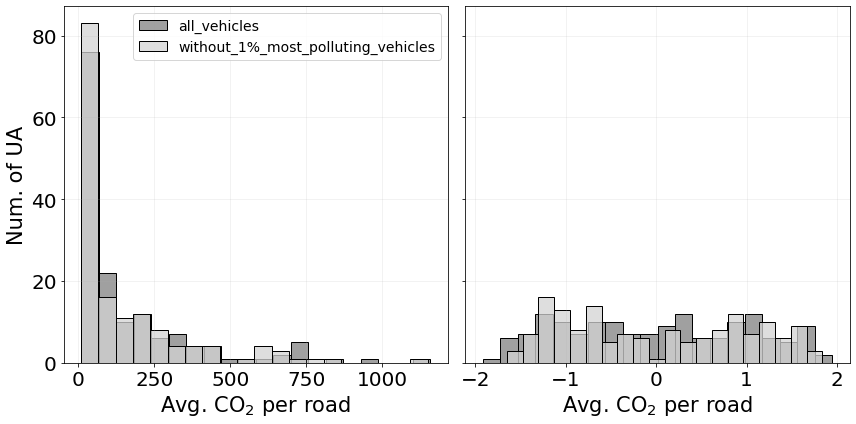

In [11]:
y = gdf_rome_connected[feature_to_predict]
y_sim = gdf_rome_connected_sim[feature_to_predict]

## y
pwt = PowerTransformer()
pwt.fit(y.values.reshape(-1, 1))

y_transformed = pd.Series(pwt.transform(y.values.reshape(-1, 1)).flatten())
y_transformed.name = "Transformed avg CO2 per road"

## y_sim
pwt = PowerTransformer()
pwt.fit(y_sim.values.reshape(-1, 1))

y_transformed_sim = pd.Series(pwt.transform(y_sim.values.reshape(-1, 1)).flatten())
y_transformed_sim.name = "Transformed avg CO2 per road (sim)"


fig, ax = plt.subplots(1,2, figsize=(12,6), sharey=True)

#ax[0].hist(y, bins=50, color='black')
sns.histplot(y, color="gray", kde=False, bins=20, ax=ax[0], label='all_vehicles')
sns.histplot(y_sim, color="lightgray", kde=False, bins=20, ax=ax[0], label=scenario_to_simulate)
#ax[0].set_title('before transformation', fontsize=15)
ax[0].set_xlabel(r'Avg. CO$_2$ per road', fontsize=axis_label_fontsize)
ax[0].set_ylabel('Num. of UA', fontsize=axis_label_fontsize)
ax[0].tick_params(axis='both', which='major', labelsize=axis_ticklabel_fontsize)
ax[0].grid(alpha=0.2)
ax[0].legend(fontsize=14)

#ax[1].hist(y_transformed, bins=50, color='black')
sns.histplot(y_transformed, color="gray", kde=False,bins=20, ax=ax[1])
sns.histplot(y_transformed_sim, color="lightgray", kde=False,bins=20, ax=ax[1])
#ax[1].set_title(r'after transformation', fontsize=15)
ax[1].set_xlabel(r'Avg. CO$_2$ per road', fontsize=axis_label_fontsize)
ax[1].set_ylabel('Num. of UA', fontsize=axis_label_fontsize)
ax[1].tick_params(axis='both', which='major', labelsize=axis_ticklabel_fontsize)
ax[1].grid(alpha=0.2)

plt.tight_layout()
#plt.subplots_adjust(wspace=0.3)

if SAVE_FIG:
    plt.savefig(PATH_TO_OUTPUT / 'hist_y_co2_transformation__simulation_10perc.pdf', format='pdf')
    plt.savefig(PATH_TO_OUTPUT / 'hist_y_co2_transformation__simulation_10perc.png', format='png', dpi=300)

plt.show()

In [12]:
## X

POWER_TRANSFORM = False

X = gdf_rome_connected[non_correlated_features]

if POWER_TRANSFORM:
    pwt = PowerTransformer()
    pwt.fit(X)
    X_transformed = pd.DataFrame(pwt.transform(X), columns=X.columns)
else:
    ss = StandardScaler()
    ss.fit(X)
    X_transformed = pd.DataFrame(ss.transform(X), columns=X.columns)

## Linear Regression

In [13]:

X = gdf_rome_connected[non_correlated_features]
y = gdf_rome_connected[feature_to_predict]

# model
preprocessor = Pipeline(steps=[("scaler", StandardScaler())])
pipe_all = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("regressor", LinearRegression()),
    ]
)
model_fixed = TransformedTargetRegressor(regressor=pipe_all, transformer=PowerTransformer())
model_fixed.fit(X, y)

# CV
cv_all = cross_validate(
    model_fixed,
    X,
    y,
    cv=RepeatedKFold(n_splits=N_SPLITS, n_repeats=N_REPEATS, random_state=RANDOM_STATE),
    return_estimator=True,
    n_jobs=-1,
)
coefs_all = pd.DataFrame(
    [est.regressor_.named_steps["regressor"].coef_ for est in cv_all["estimator"]],
    columns=X.columns,
)
coefs_all["Intercept"] = pd.Series(
    [est.regressor_.named_steps["regressor"].intercept_ for est in cv_all["estimator"]]
)
medians_all = coefs_all.drop(["Intercept"], axis=1).median()
medians_all = medians_all.reindex(medians_all.abs().sort_values(ascending=False).index)
medians_all = medians_all.append(pd.Series({"Intercept": 0}, index=["Intercept"]))
coefs_all = coefs_all[medians_all.index]


map__scenario__median_coeffs = {'all_vehicles' : medians_all}
for sim_scenario_name in map__scenario__filename.keys():
    
    # loading emissions in the scenario
    gdf_rome_sim = gpd.read_file(PATH_TO_PROCESSED_FILES / map__scenario__filename[sim_scenario_name])
    gdf_rome_sim.drop(columns=["geometry",'area_code','SHAPE_Leng','SHAPE_Area'])
    gdf_rome_connected_sim = gdf_rome_sim.drop(index=[97])
    y_sim = gdf_rome_connected_sim[feature_to_predict]
    
    # model
    preprocessor = Pipeline(steps=[("scaler", StandardScaler())])
    pipe_all = Pipeline(
        steps=[
            ("preprocessor", preprocessor),
            ("regressor", LinearRegression()),
        ]
    )

    # model with y_sim
    model_fixed_sim = TransformedTargetRegressor(regressor=pipe_all, transformer=PowerTransformer())
    model_fixed_sim.fit(X, y_sim)
    # CV
    cv_all_sim = cross_validate(
        model_fixed_sim,
        X,
        y_sim,
        cv=RepeatedKFold(n_splits=N_SPLITS, n_repeats=N_REPEATS, random_state=RANDOM_STATE),
        return_estimator=True,
        n_jobs=-1)

    coefs_all_sim = pd.DataFrame(
        [est.regressor_.named_steps["regressor"].coef_ for est in cv_all_sim["estimator"]],
        columns=X.columns,
    )
    coefs_all_sim["Intercept"] = pd.Series(
        [est.regressor_.named_steps["regressor"].intercept_ for est in cv_all_sim["estimator"]]
    )
    medians_all_sim = coefs_all_sim.drop(["Intercept"], axis=1).median()
    medians_all_sim = medians_all_sim.reindex(medians_all_sim.abs().sort_values(ascending=False).index)
    #medians_all_sim = medians_all_sim.reindex(medians_all.index)
    medians_all_sim = medians_all_sim.append(pd.Series({"Intercept": 0}, index=["Intercept"]))
    coefs_all_sim = coefs_all_sim[medians_all.index]
    
    map__scenario__median_coeffs[sim_scenario_name] = medians_all_sim

/tmp/ipykernel_6909/218324211.py:33: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  medians_all = medians_all.append(pd.Series({"Intercept": 0}, index=["Intercept"]))
/tmp/ipykernel_6909/218324211.py:77: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  medians_all_sim = medians_all_sim.append(pd.Series({"Intercept": 0}, index=["Intercept"]))
/tmp/ipykernel_6909/218324211.py:77: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  medians_all_sim = medians_all_sim.append(pd.Series({"Intercept": 0}, index=["Intercept"]))
/tmp/ipykernel_6909/218324211.py:77: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  medians_all_sim = medians_all_sim.append(pd

In [14]:
df_medians = pd.DataFrame.from_dict(map__scenario__median_coeffs)
df_medians

all_vehicles  \
Intercept                                  0.000000   
car_accidents                              0.082234   
density_all_amenities                      0.095686   
density_traffic_lights                     0.064039   
motorway_roads_density                     0.495365   
perc_people_close_to_public_transport     -0.164589   
perc_roads_bc                              0.052580   
pop_density                               -0.210944   
primary_roads_density                      0.119954   
street_density                            -0.243486   
trunk_roads_density                        0.286893   

                                       without_1%_most_polluting_vehicles  \
Intercept                                                        0.000000   
car_accidents                                                    0.045721   
density_all_amenities                                            0.006215   
density_traffic_lights                                          -0.082937   
motorway_roads_density                                           0.465464   
perc_people_close_to_public_transport                           -0.170101   
perc_roads_bc                                                    0.000079   
pop_density                                                     -0.129054   
primary_roads_density                                            0.108764   
street_density                                                  -0.222811   
trunk_roads_density                                              0.280076   

                                       without_5%_most_polluting_vehicles  \
Intercept                                                        0.000000   
car_accidents                                                    0.034294   
density_all_amenities                                           -0.038965   
density_traffic_lights                                          -0.116199   
motorway_roads_density                                           0.455630   
perc_people_close_to_public_transport                           -0.184737   
perc_roads_bc                                                    0.002847   
pop_density                                                     -0.096381   
primary_roads_density                                            0.119228   
street_density                                                  -0.186726   
trunk_roads_density                                              0.278315   

                                       without_10%_most_polluting_vehicles  
Intercept                                                         0.000000  
car_accidents                                                     0.022006  
density_all_amenities                                            -0.068496  
density_traffic_lights                                           -0.123397  
motorway_roads_density                                            0.447759  
perc_people_close_to_public_transport                            -0.164270  
perc_roads_bc                                                    -0.004845  
pop_density                                                      -0.093972  
primary_roads_density                                             0.115992  
street_density                                                   -0.187368  
trunk_roads_density                                               0.276903

In [14]:
X = gdf_rome_connected[non_correlated_features]
y = gdf_rome_connected[feature_to_predict]
y_sim = gdf_rome_connected_sim[feature_to_predict]

In [15]:
preprocessor = Pipeline(steps=[("scaler", StandardScaler())])

pipe_all = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("regressor", LinearRegression()),
    ]
)

# model with y
model_fixed = TransformedTargetRegressor(regressor=pipe_all, transformer=PowerTransformer())
model_fixed.fit(X, y)

# model with y_sim
model_fixed_sim = TransformedTargetRegressor(regressor=pipe_all, transformer=PowerTransformer())
model_fixed_sim.fit(X, y_sim)

TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                      Pipeline(steps=[('scaler',
                                                                       StandardScaler())])),
                                                     ('regressor',
                                                      LinearRegression())]),
                           transformer=PowerTransformer())

/tmp/ipykernel_31294/2101392805.py:22: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  medians_all = medians_all.append(pd.Series({"Intercept": 0}, index=["Intercept"]))
/tmp/ipykernel_31294/2101392805.py:47: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  medians_all_sim = medians_all_sim.append(pd.Series({"Intercept": 0}, index=["Intercept"]))


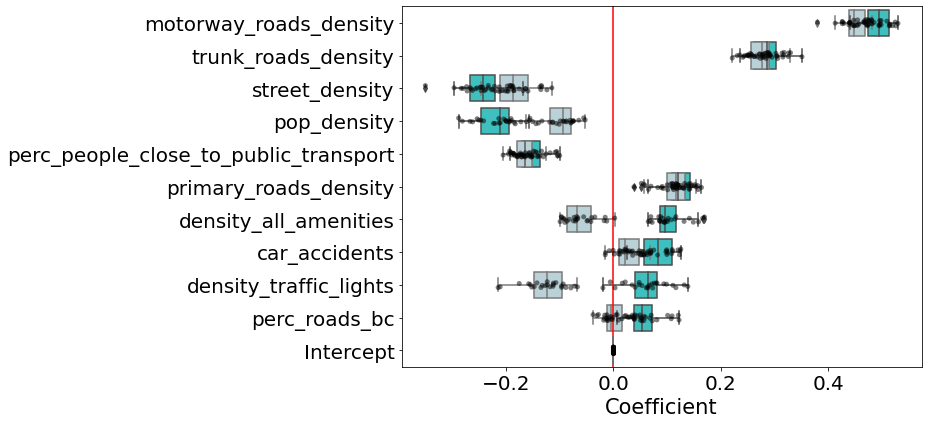

In [16]:
# CV y
cv_all = cross_validate(
    model_fixed,
    X,
    y,
    cv=RepeatedKFold(n_splits=N_SPLITS, n_repeats=N_REPEATS, random_state=RANDOM_STATE),
    return_estimator=True,
    n_jobs=-1,
)

coefs_all = pd.DataFrame(
    [est.regressor_.named_steps["regressor"].coef_ for est in cv_all["estimator"]],
    columns=X.columns,
)

coefs_all["Intercept"] = pd.Series(
    [est.regressor_.named_steps["regressor"].intercept_ for est in cv_all["estimator"]]
)

medians_all = coefs_all.drop(["Intercept"], axis=1).median()
medians_all = medians_all.reindex(medians_all.abs().sort_values(ascending=False).index)
medians_all = medians_all.append(pd.Series({"Intercept": 0}, index=["Intercept"]))
coefs_all = coefs_all[medians_all.index]

# CV y_sim
cv_all_sim = cross_validate(
    model_fixed_sim,
    X,
    y_sim,
    cv=RepeatedKFold(n_splits=N_SPLITS, n_repeats=N_REPEATS, random_state=RANDOM_STATE),
    return_estimator=True,
    n_jobs=-1,
)

coefs_all_sim = pd.DataFrame(
    [est.regressor_.named_steps["regressor"].coef_ for est in cv_all_sim["estimator"]],
    columns=X.columns,
)

coefs_all_sim["Intercept"] = pd.Series(
    [est.regressor_.named_steps["regressor"].intercept_ for est in cv_all_sim["estimator"]]
)

medians_all_sim = coefs_all_sim.drop(["Intercept"], axis=1).median()
medians_all_sim = medians_all_sim.reindex(medians_all_sim.abs().sort_values(ascending=False).index)
#medians_all_sim = medians_all_sim.reindex(medians_all.index)
medians_all_sim = medians_all_sim.append(pd.Series({"Intercept": 0}, index=["Intercept"]))
coefs_all_sim = coefs_all_sim[medians_all.index]


fig, ax = plt.subplots(figsize=(13, 6))
#plt.figure(figsize=(20, 1*len(independent_variables)))
sns.stripplot(data=coefs_all, orient="h", color="k", alpha=0.5)
sns.boxplot(data=coefs_all, orient="h", color="cyan", saturation=0.5)
sns.stripplot(data=coefs_all_sim, orient="h", color="k", alpha=0.5)
sns.boxplot(data=coefs_all_sim, orient="h", color="lightblue", saturation=0.5)
plt.axvline(x=0, color="red")
ax.tick_params(axis='both', which='major', labelsize=axis_ticklabel_fontsize)
ax.set_xlabel("Coefficient", fontsize=axis_label_fontsize)
#plt.title(f"Sensitivity Analysis. \n Coefficients of the regression model with uncorrelated features", fontsize=15)
plt.tight_layout()

if SAVE_FIG:
    plt.savefig(PATH_TO_OUTPUT / 'sensitivity_nonspatial_regression__simulation_10perc.pdf', format='pdf')
    plt.savefig(PATH_TO_OUTPUT / 'sensitivity_nonspatial_regression__simulation_10perc.png', format='png', dpi=300)

plt.show()

In [27]:
df_medians = pd.concat([medians_all, medians_all_sim], axis=1)
df_medians

0         1
motorway_roads_density                 0.495365  0.447759
trunk_roads_density                    0.286893  0.276903
street_density                        -0.243486 -0.187368
pop_density                           -0.210944 -0.093972
perc_people_close_to_public_transport -0.164589 -0.164270
primary_roads_density                  0.119954  0.115992
density_all_amenities                  0.095686 -0.068496
car_accidents                          0.082234  0.022006
density_traffic_lights                 0.064039 -0.123397
perc_roads_bc                          0.052580 -0.004845
Intercept                              0.000000  0.000000

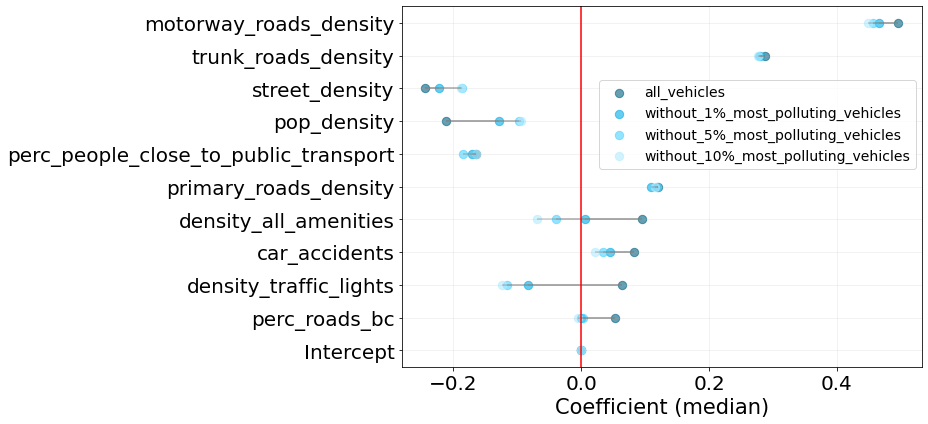

In [18]:
fig, ax = plt.subplots(figsize=(13,6))

#df_medians = pd.concat([medians_all, medians_all_sim], axis=1)
#df_medians.columns = ['all_vehicles', scenario_to_simulate]

# Reorder it following the values of the first value:
ordered_df = df_medians.sort_values(by='all_vehicles', key=abs)
my_range=range(1,len(df_medians.index)+1)

map__scenario__color = {
    'all_vehicles' : '#006080',
    'without_1%_most_polluting_vehicles' : '#00ace6',
    'without_5%_most_polluting_vehicles' : '#4dd2ff',
    'without_10%_most_polluting_vehicles' : '#b3ecff'
}

# The horizontal plot is made using the hline function
for scenario_name in ordered_df.columns:
    ax.hlines(y=my_range, xmin=ordered_df['all_vehicles'], xmax=ordered_df[scenario_name], color='grey', alpha=0.4)
    ax.scatter(ordered_df[scenario_name], my_range, s=70, color=map__scenario__color[scenario_name], marker='o', alpha=0.6, label=scenario_name)
#plt.scatter(ordered_df['all_vehicles'], my_range, s=60, color='#00b3b3', marker='o', alpha=1, label='all_vehicles')
#plt.scatter(ordered_df[scenario_to_simulate], my_range, s=60, color='lightblue', alpha=1, marker='o', label=scenario_to_simulate)
plt.axvline(x=0, color="red")
plt.legend(loc=(0.38,0.55), fontsize=14)
 
# Add title and axis names
plt.yticks(my_range, ordered_df.index)
ax.tick_params(axis='both', which='major', labelsize=axis_ticklabel_fontsize)
ax.set_xlabel("Coefficient (median)", fontsize=axis_label_fontsize)
plt.grid(alpha=0.2)
plt.tight_layout()

if SAVE_FIG:
    plt.savefig(PATH_TO_OUTPUT / 'sensitivity_nonspatial_regression__scatter__simulation_ALLperc.pdf', format='pdf')
    plt.savefig(PATH_TO_OUTPUT / 'sensitivity_nonspatial_regression__scatter__simulation_ALLperc.png', format='png', dpi=300)

# Show the graph
plt.show()

In [103]:
coefs = pd.concat([coefs_all,coefs_all_sim], axis=1)
arr_labels = np.concatenate((np.zeros(coefs_all.shape[1]), np.ones(coefs_all.shape[1])), axis=0).reshape(1,-1)
df_labels = pd.DataFrame(arr_labels, columns=coefs.columns, index=['label'])
coefs = pd.concat([coefs,df_labels],axis=0)
coefs.tail()

motorway_roads_density  trunk_roads_density  street_density  \
21                   0.519770             0.351147       -0.202011   
22                   0.474271             0.273160       -0.280239   
23                   0.515041             0.291283       -0.264781   
24                   0.498741             0.254450       -0.233231   
label                0.000000             0.000000        0.000000   

       pop_density  perc_people_close_to_public_transport  \
21       -0.242045                              -0.100286   
22       -0.200804                              -0.152783   
23       -0.262487                              -0.164589   
24       -0.190207                              -0.171053   
label     0.000000                               0.000000   

       primary_roads_density  density_all_amenities  car_accidents  \
21                  0.119301               0.094083       0.035513   
22                  0.139330               0.158383       0.051812   
23                  0.130404               0.099148       0.099514   
24                  0.101036               0.072164       0.120082   
label               0.000000               0.000000       0.000000   

       density_traffic_lights  perc_roads_bc  ...  trunk_roads_density  \
21                   0.064039       0.072402  ...             0.329811   
22                   0.073080       0.049151  ...             0.250888   
23                   0.138587       0.026295  ...             0.284380   
24                   0.002926       0.050261  ...             0.256598   
label                0.000000       0.000000  ...             1.000000   

       street_density  pop_density  perc_people_close_to_public_transport  \
21          -0.133610    -0.139701                              -0.104317   
22          -0.238092    -0.078946                              -0.160082   
23          -0.197762    -0.133312                              -0.178665   
24          -0.192879    -0.091686                              -0.164270   
label        1.000000     1.000000                               1.000000   

       primary_roads_density  density_all_amenities  car_accidents  \
21                  0.111550              -0.073365      -0.007698   
22                  0.140969               0.002341       0.011837   
23                  0.120439              -0.070693       0.053748   
24                  0.082532              -0.091571       0.065283   
label               1.000000               1.000000       1.000000   

       density_traffic_lights  perc_roads_bc     Intercept  
21                  -0.111890       0.015833 -1.116394e-15  
22                  -0.157896      -0.001479  2.847166e-16  
23                  -0.072282      -0.028140  6.971759e-16  
24                  -0.147592      -0.012033 -1.382722e-16  
label                1.000000       1.000000  1.000000e+00  

[5 rows x 22 columns]

In [99]:
np.concatenate((np.zeros(coefs_all.shape[1]), np.ones(coefs_all.shape[1])), axis=0).reshape(1,-1).shape

(1, 22)

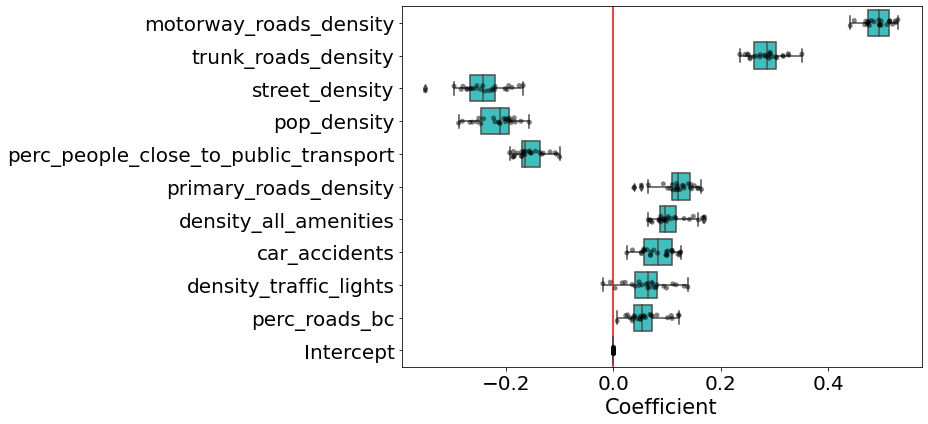

In [107]:
fig, ax = plt.subplots(figsize=(13, 6))
#plt.figure(figsize=(20, 1*len(independent_variables)))
sns.stripplot(data=coefs_all, orient="h", color="k", alpha=0.5)
sns.boxplot(data=coefs_all, orient="h", color="cyan", saturation=0.5)
plt.axvline(x=0, color="red")
ax.tick_params(axis='both', which='major', labelsize=axis_ticklabel_fontsize)
ax.set_xlabel("Coefficient", fontsize=axis_label_fontsize)
#plt.title(f"Sensitivity Analysis. \n Coefficients of the regression model with uncorrelated features", fontsize=15)
plt.tight_layout()

if SAVE_FIG:
    plt.savefig(PATH_TO_OUTPUT / 'sensitivity_nonspatial_regression__simulation_10perc.pdf', format='pdf')
    plt.savefig(PATH_TO_OUTPUT / 'sensitivity_nonspatial_regression__simulation_10perc.png', format='png', dpi=300)

plt.show()

The coefficients associated to the density of POIs and traffic lights become negative. This may be due to the fact that the most polluting vehicles prevalently move through the city center. Thus, as both POIs and traffic lights are more present in the city center, once removed the most polluting vehicles, the higher the density of these two features (i.e. the more centric is the UA), the lower the emissions.
This fact may be verified empirically with a heatmap of the points of the most polluting vehicles.

## Random Forest

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y_transformed, test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [19]:
## Define Grid 
grid = { 
    'n_estimators': [100,200,300],
    'max_features': ['auto', 'sqrt'], #'log2'
    'max_depth' : [None,2,3],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
}

## Grid Search function
rf_cv = GridSearchCV(estimator=RandomForestRegressor(), param_grid=grid, cv=N_SPLITS)
rf_cv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [None, 2, 3],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]})

In [20]:
dict_params_best_model = rf_cv.best_estimator_.get_params(deep=False)
dict_params_best_model

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 3,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [21]:
N_SPLITS=5
N_REPEATS=5

cv = cross_validate(
    rf_cv.best_estimator_,
    X_test,
    y_test,
    cv=RepeatedKFold(n_splits=N_SPLITS, n_repeats=N_REPEATS, random_state=RANDOM_STATE),
    return_estimator=True,
    n_jobs=-1,
    scoring='neg_median_absolute_error'
)
print("%0.2f with a standard deviation of %0.2f" %(cv['test_score'].mean(), cv['test_score'].std()))

-0.44 with a standard deviation of 0.12


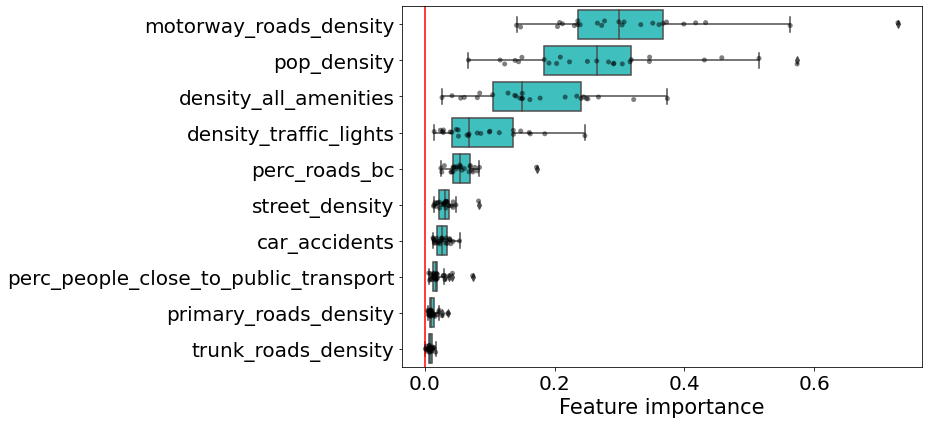

In [22]:
## impurity-based feature importance

importances = pd.DataFrame(
    [est.feature_importances_ for est in cv["estimator"]],
    columns=X.columns,
)

medians_all = importances.median()
medians_all = medians_all.reindex(medians_all.abs().sort_values(ascending=False).index)
importances = importances[medians_all.index]


fig, ax = plt.subplots(figsize=(13, 6))
#plt.figure(figsize=(20, 1*len(independent_variables)))
sns.stripplot(data=importances, orient="h", color="k", alpha=0.5)
sns.boxplot(data=importances, orient="h", color="cyan", saturation=0.5)
plt.axvline(x=0, color="red")
ax.tick_params(axis='both', which='major', labelsize=axis_ticklabel_fontsize)
ax.set_xlabel("Feature importance", fontsize=axis_label_fontsize)
#plt.title(f"Sensitivity Analysis. \n Coefficients of the regression model with uncorrelated features", fontsize=15)
plt.tight_layout()

if SAVE_FIG:
    plt.savefig(PATH_TO_OUTPUT / 'feature_importance_random_forest__.pdf', format='pdf')
    plt.savefig(PATH_TO_OUTPUT / 'feature_importance_random_forest__.png', format='png')

plt.show()

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y_transformed, test_size=TEST_SIZE, random_state=RANDOM_STATE)

## Define Grid 
grid = { 
    'n_estimators': [100,200,300],
    'max_features': ['auto', 'sqrt'], #'log2'
    'max_depth' : [None,2,3],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
}

## Grid Search function
rf_cv = GridSearchCV(estimator=RandomForestRegressor(), param_grid=grid, cv=N_SPLITS)
rf_cv.fit(X_train, y_train)

# CV
cv = cross_validate(
    rf_cv.best_estimator_,
    X_test,
    y_test,
    cv=RepeatedKFold(n_splits=N_SPLITS, n_repeats=N_REPEATS, random_state=RANDOM_STATE),
    return_estimator=True,
    n_jobs=-1,
    scoring='neg_median_absolute_error'
)
## impurity-based feature importance
importances = pd.DataFrame(
    [est.feature_importances_ for est in cv["estimator"]],
    columns=X.columns,
)
medians_all = importances.median()
medians_all = medians_all.reindex(medians_all.abs().sort_values(ascending=False).index)
importances = importances[medians_all.index]


map__scenario__median_coeffs = {'all_vehicles' : medians_all}
for sim_scenario_name in map__scenario__filename.keys():
    
    # loading emissions in the scenario
    gdf_rome_sim = gpd.read_file(PATH_TO_PROCESSED_FILES / map__scenario__filename[sim_scenario_name])
    gdf_rome_sim.drop(columns=["geometry",'area_code','SHAPE_Leng','SHAPE_Area'])
    gdf_rome_connected_sim = gdf_rome_sim.drop(index=[97])
    y_sim = gdf_rome_connected_sim[feature_to_predict]
    
    ## transforming y_sim
    pwt = PowerTransformer()
    pwt.fit(y_sim.values.reshape(-1, 1))
    y_transformed_sim = pd.Series(pwt.transform(y_sim.values.reshape(-1, 1)).flatten())
    y_transformed_sim.name = "Transformed avg CO2 per road (sim)"
    
    X_train, X_test, y_train_sim, y_test_sim = train_test_split(X_transformed, y_transformed_sim, test_size=TEST_SIZE, random_state=RANDOM_STATE)

    # model with y_sim
    rf_cv_sim = GridSearchCV(estimator=RandomForestRegressor(), param_grid=grid, cv=N_SPLITS)
    rf_cv_sim.fit(X_train, y_train_sim)
    # CV
    cv_sim = cross_validate(
        rf_cv_sim.best_estimator_,
        X_test,
        y_test_sim,
        cv=RepeatedKFold(n_splits=N_SPLITS, n_repeats=N_REPEATS, random_state=RANDOM_STATE),
        return_estimator=True,
        n_jobs=-1,
        scoring='neg_median_absolute_error'
    )
    ## impurity-based feature importance
    importances_sim = pd.DataFrame(
        [est.feature_importances_ for est in cv_sim["estimator"]],
        columns=X.columns,
    )
    medians_all_sim = importances_sim.median()
    medians_all_sim = medians_all_sim.reindex(medians_all_sim.abs().sort_values(ascending=False).index)
    importances_sim = importances_sim[medians_all_sim.index]
    
    map__scenario__median_coeffs[sim_scenario_name] = medians_all_sim

In [27]:
df_medians = pd.DataFrame.from_dict(map__scenario__median_coeffs)
df_medians

all_vehicles  \
car_accidents                              0.021922   
density_all_amenities                      0.149087   
density_traffic_lights                     0.080295   
motorway_roads_density                     0.295688   
perc_people_close_to_public_transport      0.015648   
perc_roads_bc                              0.057025   
pop_density                                0.270139   
primary_roads_density                      0.009916   
street_density                             0.032031   
trunk_roads_density                        0.006663   

                                       without_1%_most_polluting_vehicles  \
car_accidents                                                    0.028748   
density_all_amenities                                            0.245736   
density_traffic_lights                                           0.082997   
motorway_roads_density                                           0.222262   
perc_people_close_to_public_transport                            0.010811   
perc_roads_bc                                                    0.008714   
pop_density                                                      0.291288   
primary_roads_density                                            0.011389   
street_density                                                   0.027214   
trunk_roads_density                                              0.020321   

                                       without_5%_most_polluting_vehicles  \
car_accidents                                                    0.034923   
density_all_amenities                                            0.245743   
density_traffic_lights                                           0.081370   
motorway_roads_density                                           0.225540   
perc_people_close_to_public_transport                            0.012002   
perc_roads_bc                                                    0.008609   
pop_density                                                      0.313657   
primary_roads_density                                            0.009246   
street_density                                                   0.024990   
trunk_roads_density                                              0.016339   

                                       without_10%_most_polluting_vehicles  
car_accidents                                                     0.033151  
density_all_amenities                                             0.220945  
density_traffic_lights                                            0.089317  
motorway_roads_density                                            0.200654  
perc_people_close_to_public_transport                             0.015293  
perc_roads_bc                                                     0.013624  
pop_density                                                       0.314426  
primary_roads_density                                             0.007845  
street_density                                                    0.024960  
trunk_roads_density                                               0.022647

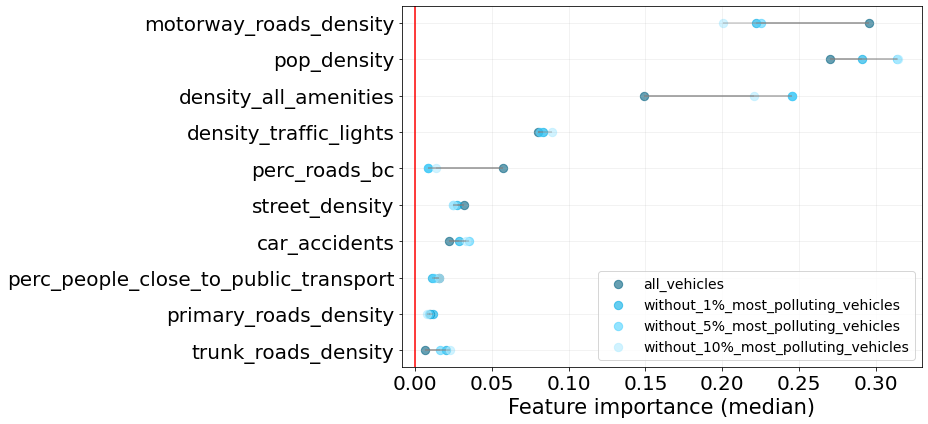

In [30]:
fig, ax = plt.subplots(figsize=(13,6))

#df_medians = pd.concat([medians_all, medians_all_sim], axis=1)
#df_medians.columns = ['all_vehicles', scenario_to_simulate]

# Reorder it following the values of the first value:
ordered_df = df_medians.sort_values(by='all_vehicles', key=abs)
my_range=range(1,len(df_medians.index)+1)

map__scenario__color = {
    'all_vehicles' : '#006080',
    'without_1%_most_polluting_vehicles' : '#00ace6',
    'without_5%_most_polluting_vehicles' : '#4dd2ff',
    'without_10%_most_polluting_vehicles' : '#b3ecff'
}

# The horizontal plot is made using the hline function
for scenario_name in ordered_df.columns:
    ax.hlines(y=my_range, xmin=ordered_df['all_vehicles'], xmax=ordered_df[scenario_name], color='grey', alpha=0.4)
    ax.scatter(ordered_df[scenario_name], my_range, s=70, color=map__scenario__color[scenario_name], marker='o', alpha=0.6, label=scenario_name)
#plt.scatter(ordered_df['all_vehicles'], my_range, s=60, color='#00b3b3', marker='o', alpha=1, label='all_vehicles')
#plt.scatter(ordered_df[scenario_to_simulate], my_range, s=60, color='lightblue', alpha=1, marker='o', label=scenario_to_simulate)
plt.axvline(x=0, color="red")
plt.legend(loc='best', fontsize=14)
 
# Add title and axis names
plt.yticks(my_range, ordered_df.index)
ax.tick_params(axis='both', which='major', labelsize=axis_ticklabel_fontsize)
ax.set_xlabel("Feature importance (median)", fontsize=axis_label_fontsize)
plt.grid(alpha=0.2)
plt.tight_layout()

if SAVE_FIG:
    plt.savefig(PATH_TO_OUTPUT / 'feature_importance_random_forest__simulation_ALLperc.pdf', format='pdf')
    plt.savefig(PATH_TO_OUTPUT / 'feature_importance_random_forest__simulation_ALLperc.png', format='png', dpi=300)

# Show the graph
plt.show()

## GWR

In [59]:
def plot_maps_feature_coefs_in_each_area(gdf_orig, gwr_results, gwr_columns, coefs_gwr, sim_name, FIT_INTERCEPT, SAVE_FIG):
    
    # collecting coefficients for each area
    geo_coefs = gdf_orig[['area_name', 'geometry', 'centroid']].copy()
    for col in coefs_gwr.columns:
        #     if col != "Intercept":
        #     if True:
        geo_coefs.loc[:,col] = coefs_gwr[col].values
    # Get t-vals of coefficientes
    gwr_filtered_t = pd.DataFrame(gwr_results.filter_tvals(), columns=gwr_columns)
    gwr_filtered_t.index = gdf_rome_connected.index

    # Copy coefficients in new dataframe so non-significant can later be removed
    geo_significant_coefs = geo_coefs.copy()
    
    for col in coefs_gwr.columns:
        print(col)
        fig, ax = plt.subplots(figsize=(8, 8))
        min_coef = geo_coefs[gwr_filtered_t.loc[:, col] != 0][col].min()
        max_coef = geo_coefs[gwr_filtered_t.loc[:, col] != 0][col].max()

        cool_warm_cmap = plt.cm.coolwarm

        if min_coef < 0 and max_coef < 0:
            interval = np.linspace(0, 0.5)
            colors = cool_warm_cmap(interval)
            cool_warm_cmap = plt_colors.LinearSegmentedColormap.from_list("name", colors)
            vmin = min_coef
            vmax = 0
        elif min_coef > 0 and max_coef > 0:
            interval = np.linspace(0.5, 1)
            colors = cool_warm_cmap(interval)
            cool_warm_cmap = plt_colors.LinearSegmentedColormap.from_list("name", colors)
            vmin = 0
            vmax = max_coef
        else:
            vmax = max(abs(min_coef), abs(max_coef))
            vmin = -vmax

        geo_coefs.plot(
            ax=ax,
            edgecolor="black",
            column=col,
            legend=True,
            vmin=vmin,
            vmax=vmax,
            cmap=cool_warm_cmap,
            legend_kwds={"shrink": 0.5},
        )
        if (gwr_filtered_t.loc[:, col] == 0).any():
            geo_coefs[gwr_filtered_t.loc[:, col] == 0].plot(
                color="lightgrey", ax=ax, **{"edgecolor": "black"}
            )
            temp = geo_significant_coefs[[col]]
            temp[gwr_filtered_t.loc[:, col] == 0] = np.nan
            geo_significant_coefs.loc[:,col] = temp[col]

        cbar = ax.get_figure().get_axes()[1]
        cbar.tick_params(labelsize=axis_ticklabel_fontsize)
        #cbar.set_ylabel('coefficient', fontsize=axis_label_fontsize)

        #ax.set_title("Coefficients of {}".format(col), fontsize=20, y=1.01)
        ax.set_axis_off()
        plt.tight_layout()
        #'''

        if SAVE_FIG:
            import re
            #sim_number = re.findall(r'\d+', sim_name)[0]
            #fig_name = "map_coefficients_GWR_%s__simulation_%sperc.png" %(col,sim_number)
            fig_name = "map_coefficients_GWR_%s.png" %(col)
            plt.savefig(
                PATH_TO_OUTPUT / fig_name,
                format="png", bbox_inches='tight', dpi=300
            )
        #'''

        plt.show()

In [21]:
coords = np.column_stack([gdf_rome_connected["geometry"].centroid.x, gdf_rome_connected["geometry"].centroid.y])
gdf_rome_connected["centroid"] = gdf_rome_connected["geometry"].centroid


# transforming (and scaling) y
pwt = PowerTransformer()
pwt.fit(y.values.reshape(-1, 1))

y_transformed = pwt.transform(y.values.reshape(-1, 1))
# scaling X
ss = StandardScaler()
X_transformed = ss.fit_transform(X)

/tmp/ipykernel_7241/3159351639.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  coords = np.column_stack([gdf_rome_connected["geometry"].centroid.x, gdf_rome_connected["geometry"].centroid.y])
/tmp/ipykernel_7241/3159351639.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  coords = np.column_stack([gdf_rome_connected["geometry"].centroid.x, gdf_rome_connected["geometry"].centroid.y])
/tmp/ipykernel_7241/3159351639.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_rome_connected["centroid"] = gdf_rome_connected["geometry"].centroid


motorway_roads_density


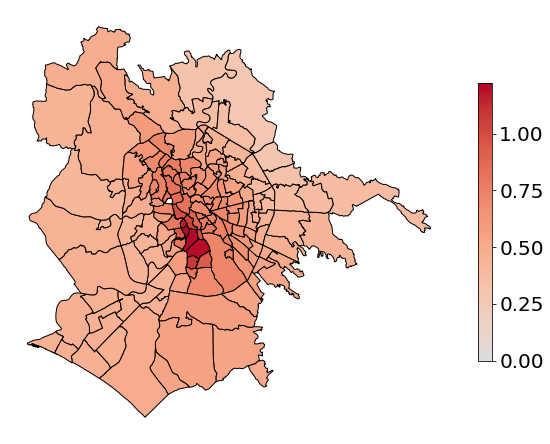

pop_density


/tmp/ipykernel_7241/2727747234.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[gwr_filtered_t.loc[:, col] == 0] = np.nan
/tmp/ipykernel_7241/2727747234.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[gwr_filtered_t.loc[:, col] == 0] = np.nan


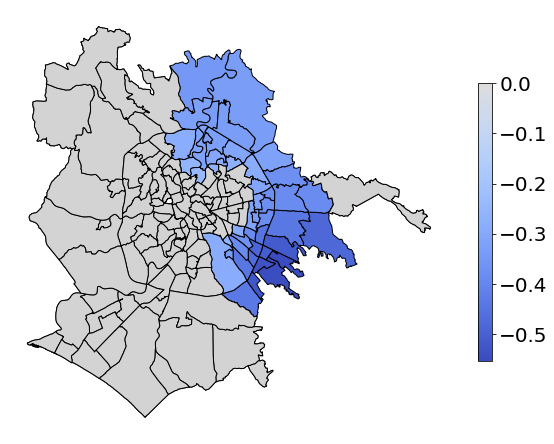

trunk_roads_density


/tmp/ipykernel_7241/2727747234.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[gwr_filtered_t.loc[:, col] == 0] = np.nan
/tmp/ipykernel_7241/2727747234.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[gwr_filtered_t.loc[:, col] == 0] = np.nan


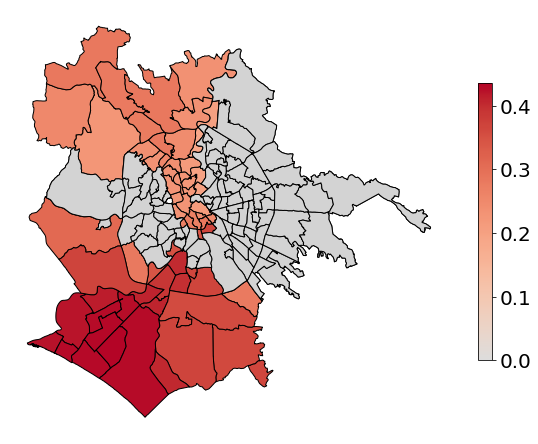

car_accidents


/tmp/ipykernel_7241/2727747234.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[gwr_filtered_t.loc[:, col] == 0] = np.nan
/tmp/ipykernel_7241/2727747234.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[gwr_filtered_t.loc[:, col] == 0] = np.nan


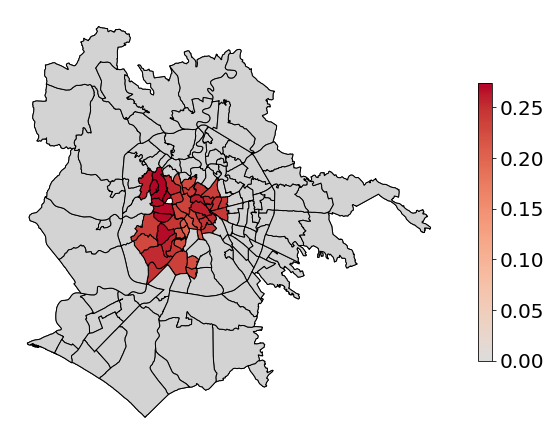

street_density


/tmp/ipykernel_7241/2727747234.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[gwr_filtered_t.loc[:, col] == 0] = np.nan
/tmp/ipykernel_7241/2727747234.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[gwr_filtered_t.loc[:, col] == 0] = np.nan


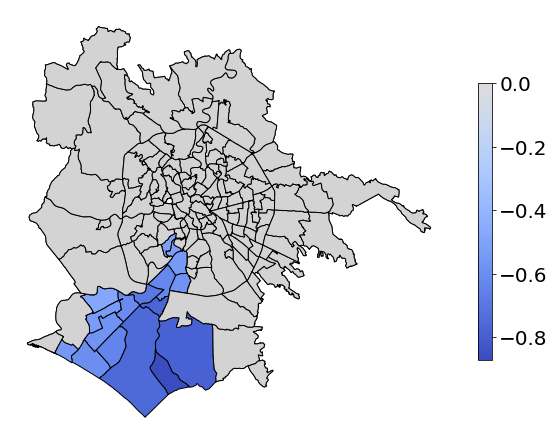

perc_people_close_to_public_transport


/tmp/ipykernel_7241/2727747234.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[gwr_filtered_t.loc[:, col] == 0] = np.nan
/tmp/ipykernel_7241/2727747234.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[gwr_filtered_t.loc[:, col] == 0] = np.nan


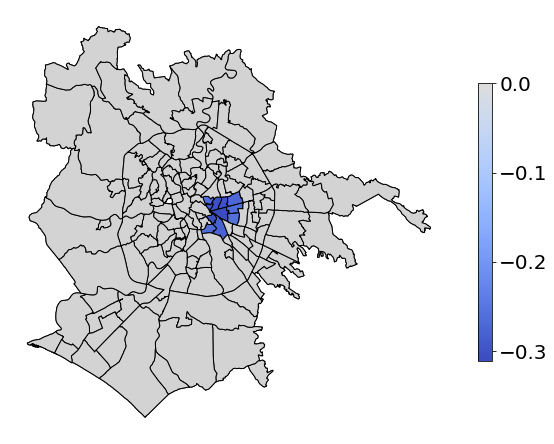

perc_roads_bc


/tmp/ipykernel_7241/2727747234.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[gwr_filtered_t.loc[:, col] == 0] = np.nan
/tmp/ipykernel_7241/2727747234.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[gwr_filtered_t.loc[:, col] == 0] = np.nan


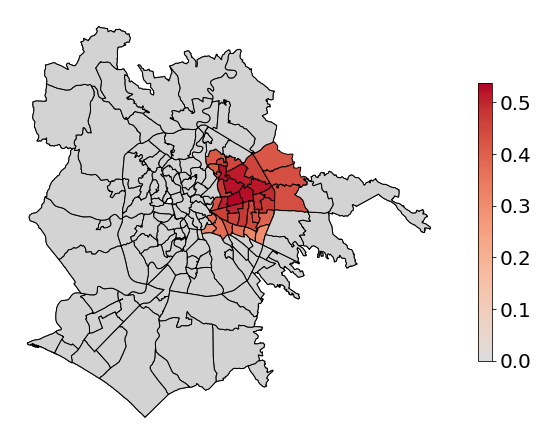

density_all_amenities


/tmp/ipykernel_7241/2727747234.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[gwr_filtered_t.loc[:, col] == 0] = np.nan
/tmp/ipykernel_7241/2727747234.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[gwr_filtered_t.loc[:, col] == 0] = np.nan


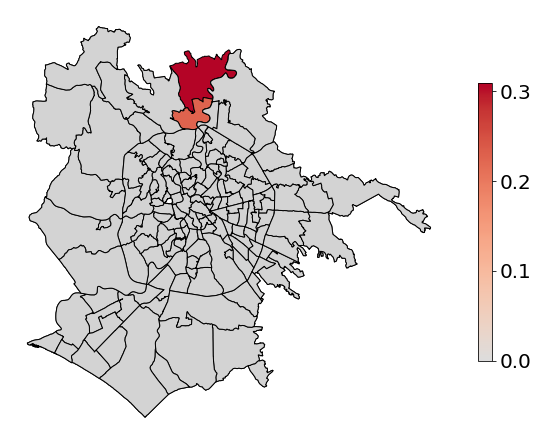

density_traffic_lights


/tmp/ipykernel_7241/2727747234.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[gwr_filtered_t.loc[:, col] == 0] = np.nan
/tmp/ipykernel_7241/2727747234.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[gwr_filtered_t.loc[:, col] == 0] = np.nan


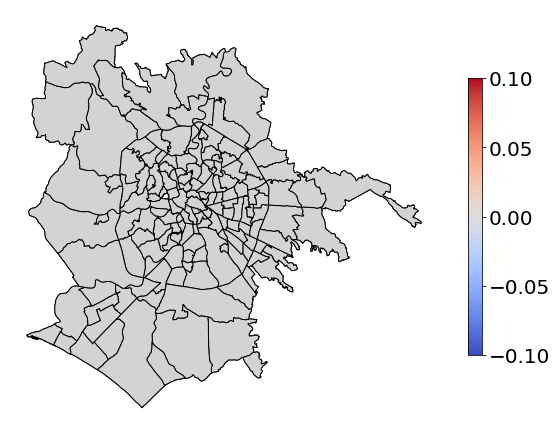

primary_roads_density


/tmp/ipykernel_7241/2727747234.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[gwr_filtered_t.loc[:, col] == 0] = np.nan
/tmp/ipykernel_7241/2727747234.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[gwr_filtered_t.loc[:, col] == 0] = np.nan


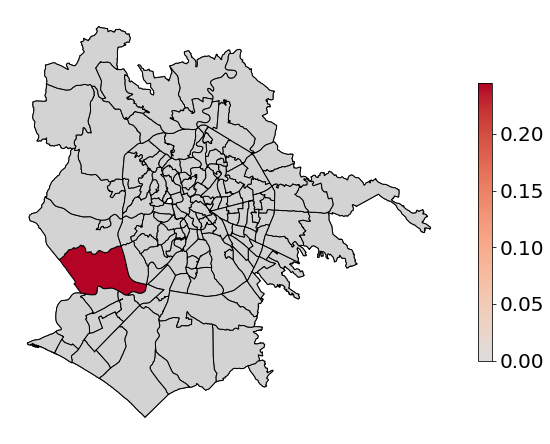

motorway_roads_density


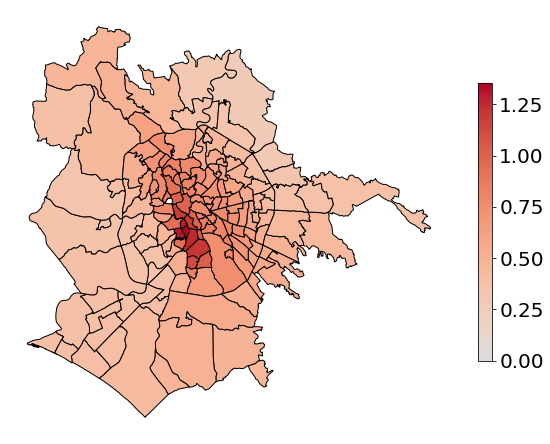

trunk_roads_density


/tmp/ipykernel_7241/2727747234.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[gwr_filtered_t.loc[:, col] == 0] = np.nan
/tmp/ipykernel_7241/2727747234.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[gwr_filtered_t.loc[:, col] == 0] = np.nan


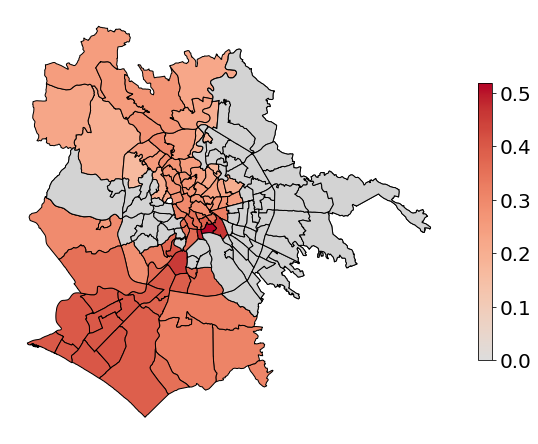

perc_people_close_to_public_transport


/tmp/ipykernel_7241/2727747234.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[gwr_filtered_t.loc[:, col] == 0] = np.nan
/tmp/ipykernel_7241/2727747234.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[gwr_filtered_t.loc[:, col] == 0] = np.nan


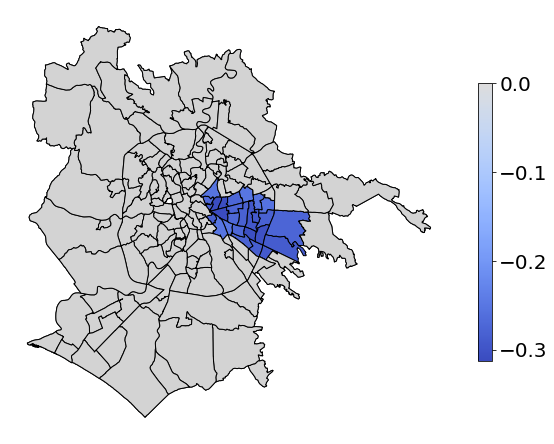

car_accidents


/tmp/ipykernel_7241/2727747234.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[gwr_filtered_t.loc[:, col] == 0] = np.nan
/tmp/ipykernel_7241/2727747234.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[gwr_filtered_t.loc[:, col] == 0] = np.nan


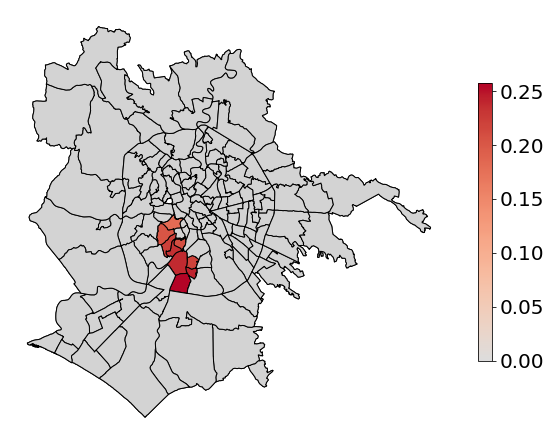

street_density


/tmp/ipykernel_7241/2727747234.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[gwr_filtered_t.loc[:, col] == 0] = np.nan
/tmp/ipykernel_7241/2727747234.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[gwr_filtered_t.loc[:, col] == 0] = np.nan


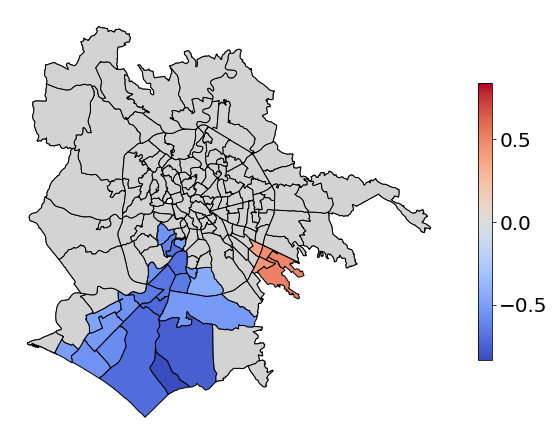

pop_density


/tmp/ipykernel_7241/2727747234.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[gwr_filtered_t.loc[:, col] == 0] = np.nan
/tmp/ipykernel_7241/2727747234.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[gwr_filtered_t.loc[:, col] == 0] = np.nan


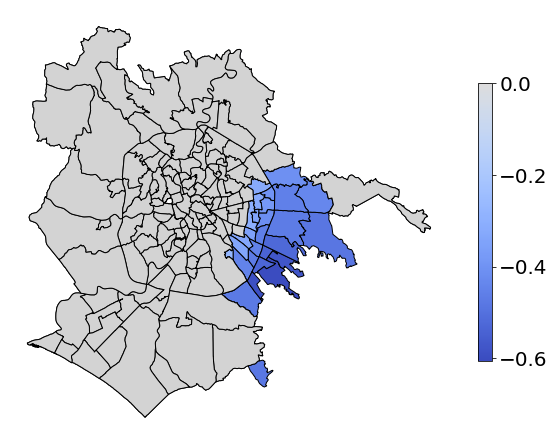

density_traffic_lights


/tmp/ipykernel_7241/2727747234.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[gwr_filtered_t.loc[:, col] == 0] = np.nan
/tmp/ipykernel_7241/2727747234.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[gwr_filtered_t.loc[:, col] == 0] = np.nan


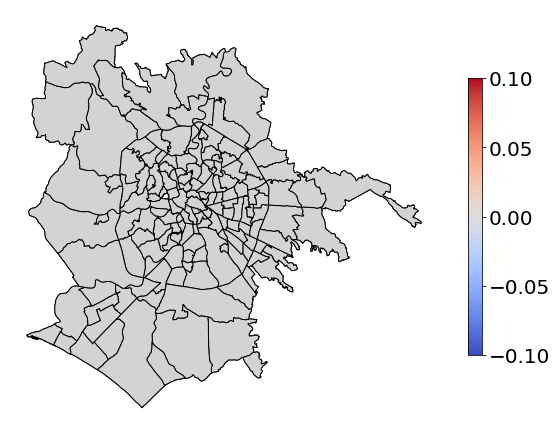

perc_roads_bc


/tmp/ipykernel_7241/2727747234.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[gwr_filtered_t.loc[:, col] == 0] = np.nan
/tmp/ipykernel_7241/2727747234.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[gwr_filtered_t.loc[:, col] == 0] = np.nan


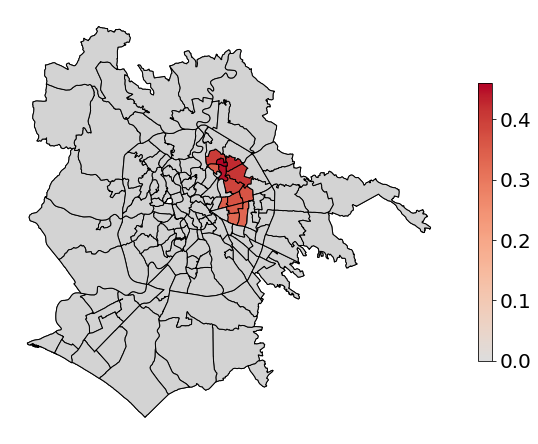

primary_roads_density


/tmp/ipykernel_7241/2727747234.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[gwr_filtered_t.loc[:, col] == 0] = np.nan
/tmp/ipykernel_7241/2727747234.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[gwr_filtered_t.loc[:, col] == 0] = np.nan


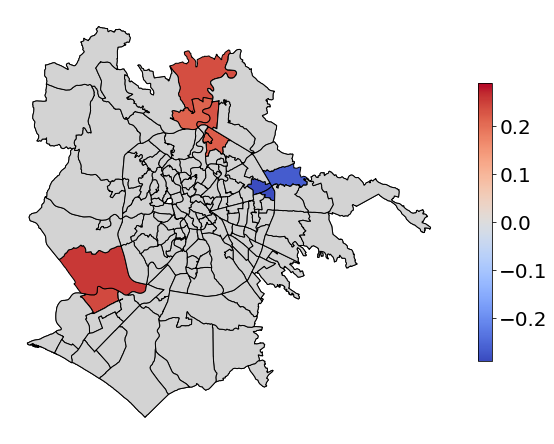

density_all_amenities


/tmp/ipykernel_7241/2727747234.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[gwr_filtered_t.loc[:, col] == 0] = np.nan
/tmp/ipykernel_7241/2727747234.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[gwr_filtered_t.loc[:, col] == 0] = np.nan


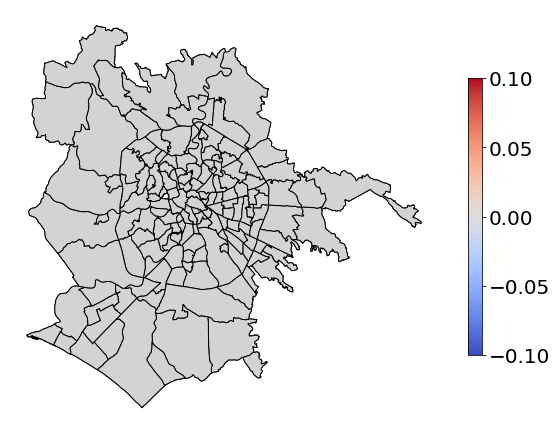

motorway_roads_density


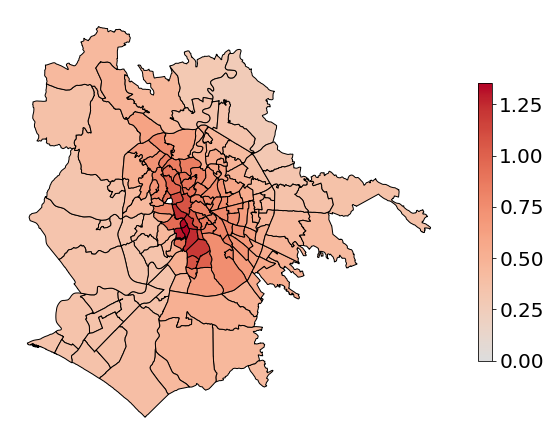

trunk_roads_density


/tmp/ipykernel_7241/2727747234.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[gwr_filtered_t.loc[:, col] == 0] = np.nan
/tmp/ipykernel_7241/2727747234.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[gwr_filtered_t.loc[:, col] == 0] = np.nan


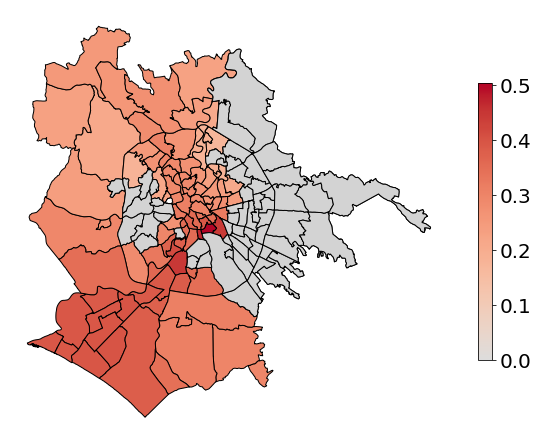

perc_people_close_to_public_transport


/tmp/ipykernel_7241/2727747234.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[gwr_filtered_t.loc[:, col] == 0] = np.nan
/tmp/ipykernel_7241/2727747234.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[gwr_filtered_t.loc[:, col] == 0] = np.nan


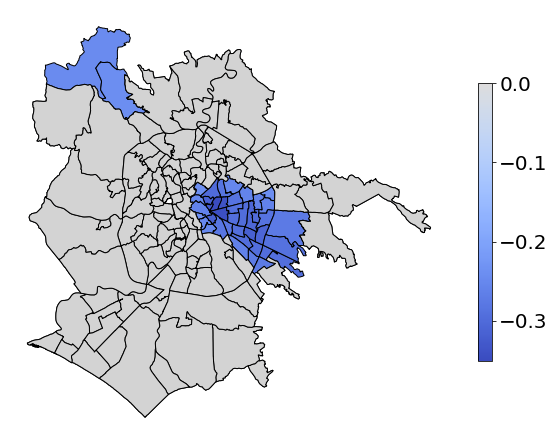

density_traffic_lights


/tmp/ipykernel_7241/2727747234.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[gwr_filtered_t.loc[:, col] == 0] = np.nan
/tmp/ipykernel_7241/2727747234.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[gwr_filtered_t.loc[:, col] == 0] = np.nan


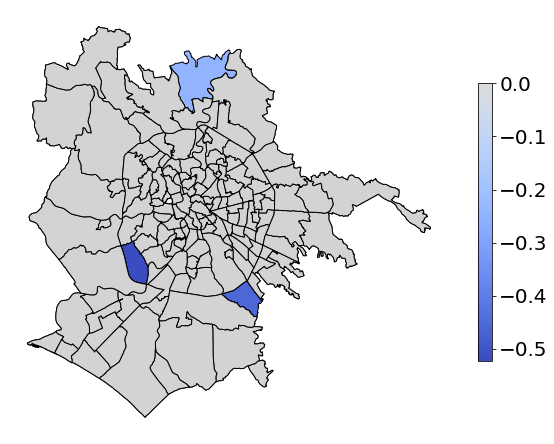

car_accidents


/tmp/ipykernel_7241/2727747234.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[gwr_filtered_t.loc[:, col] == 0] = np.nan
/tmp/ipykernel_7241/2727747234.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[gwr_filtered_t.loc[:, col] == 0] = np.nan


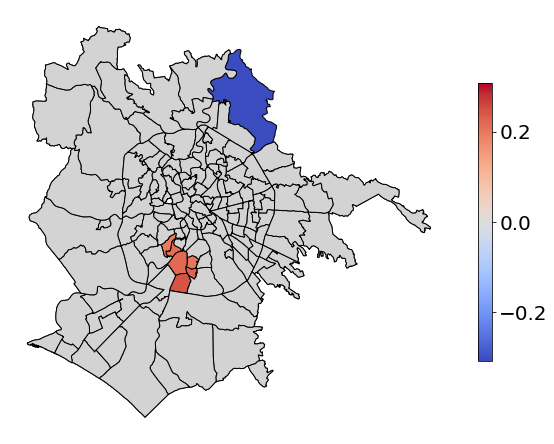

street_density


/tmp/ipykernel_7241/2727747234.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[gwr_filtered_t.loc[:, col] == 0] = np.nan
/tmp/ipykernel_7241/2727747234.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[gwr_filtered_t.loc[:, col] == 0] = np.nan


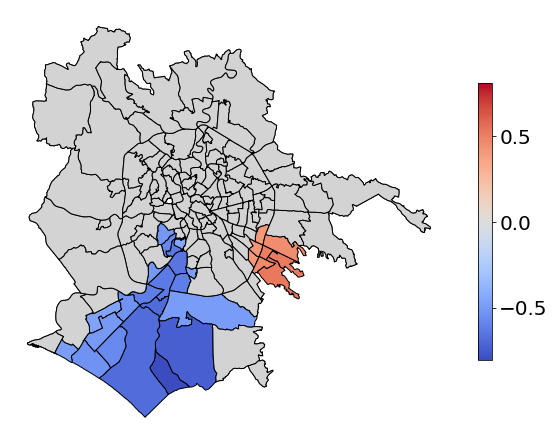

density_all_amenities


/tmp/ipykernel_7241/2727747234.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[gwr_filtered_t.loc[:, col] == 0] = np.nan
/tmp/ipykernel_7241/2727747234.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[gwr_filtered_t.loc[:, col] == 0] = np.nan


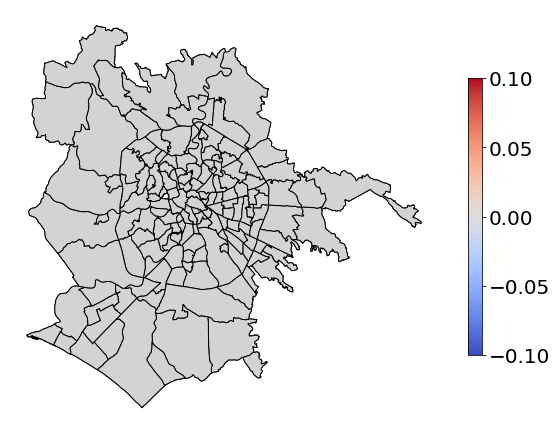

primary_roads_density


/tmp/ipykernel_7241/2727747234.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[gwr_filtered_t.loc[:, col] == 0] = np.nan
/tmp/ipykernel_7241/2727747234.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[gwr_filtered_t.loc[:, col] == 0] = np.nan


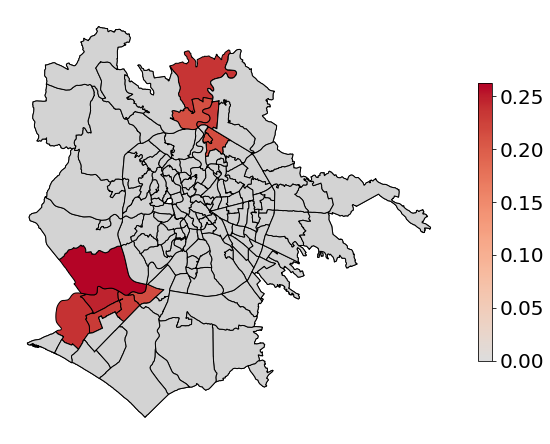

perc_roads_bc


/tmp/ipykernel_7241/2727747234.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[gwr_filtered_t.loc[:, col] == 0] = np.nan
/tmp/ipykernel_7241/2727747234.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[gwr_filtered_t.loc[:, col] == 0] = np.nan


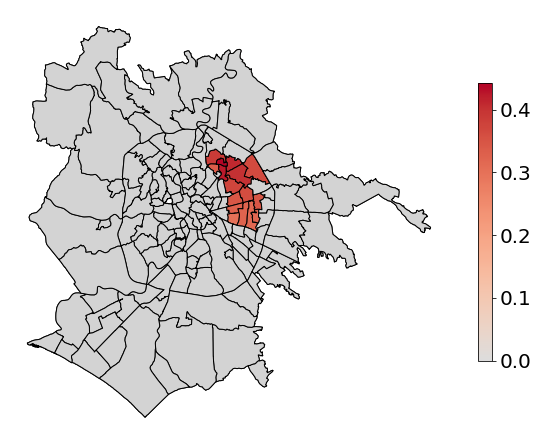

pop_density


/tmp/ipykernel_7241/2727747234.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[gwr_filtered_t.loc[:, col] == 0] = np.nan
/tmp/ipykernel_7241/2727747234.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[gwr_filtered_t.loc[:, col] == 0] = np.nan


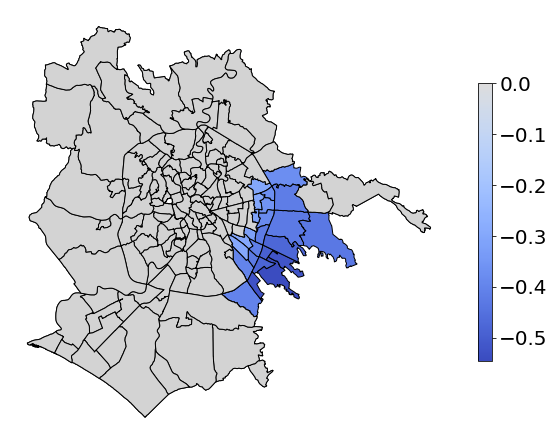

motorway_roads_density


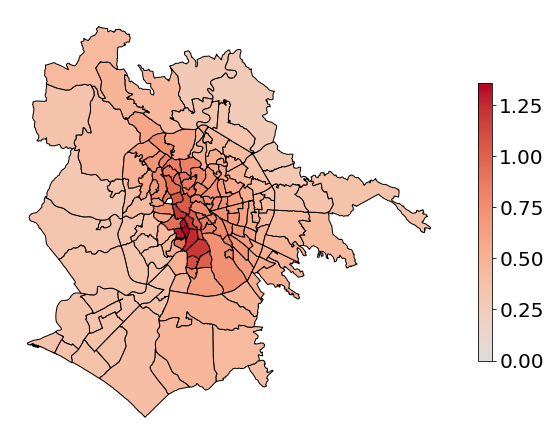

trunk_roads_density


/tmp/ipykernel_7241/2727747234.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[gwr_filtered_t.loc[:, col] == 0] = np.nan
/tmp/ipykernel_7241/2727747234.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[gwr_filtered_t.loc[:, col] == 0] = np.nan


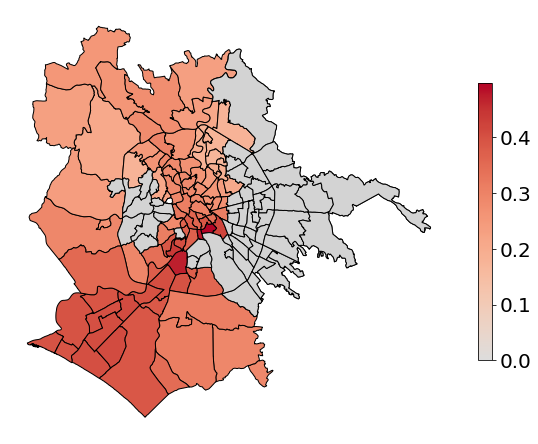

perc_people_close_to_public_transport


/tmp/ipykernel_7241/2727747234.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[gwr_filtered_t.loc[:, col] == 0] = np.nan
/tmp/ipykernel_7241/2727747234.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[gwr_filtered_t.loc[:, col] == 0] = np.nan


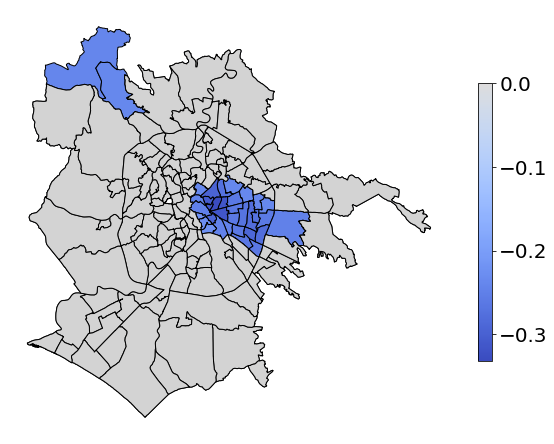

density_traffic_lights


/tmp/ipykernel_7241/2727747234.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[gwr_filtered_t.loc[:, col] == 0] = np.nan
/tmp/ipykernel_7241/2727747234.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[gwr_filtered_t.loc[:, col] == 0] = np.nan


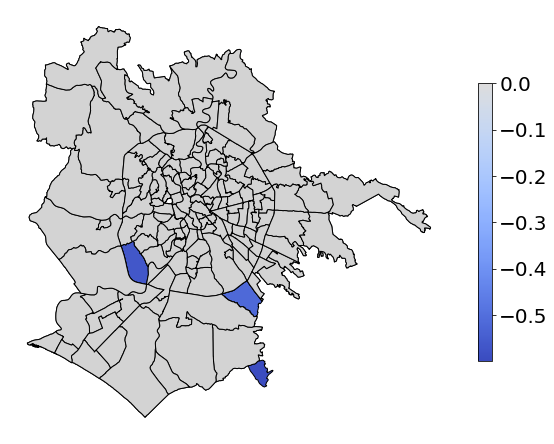

density_all_amenities


/tmp/ipykernel_7241/2727747234.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[gwr_filtered_t.loc[:, col] == 0] = np.nan
/tmp/ipykernel_7241/2727747234.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[gwr_filtered_t.loc[:, col] == 0] = np.nan


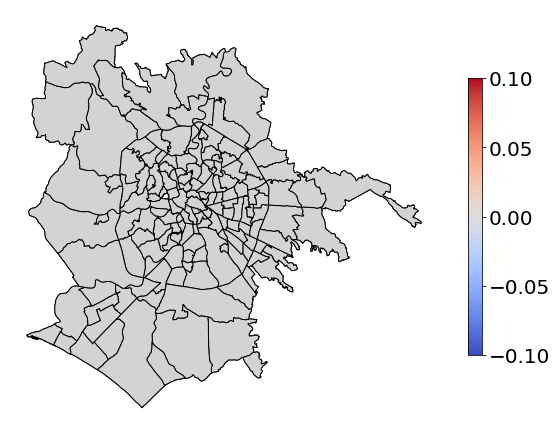

car_accidents


/tmp/ipykernel_7241/2727747234.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[gwr_filtered_t.loc[:, col] == 0] = np.nan
/tmp/ipykernel_7241/2727747234.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[gwr_filtered_t.loc[:, col] == 0] = np.nan


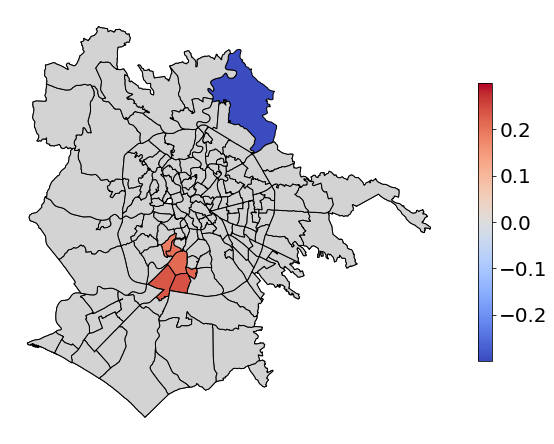

street_density


/tmp/ipykernel_7241/2727747234.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[gwr_filtered_t.loc[:, col] == 0] = np.nan
/tmp/ipykernel_7241/2727747234.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[gwr_filtered_t.loc[:, col] == 0] = np.nan


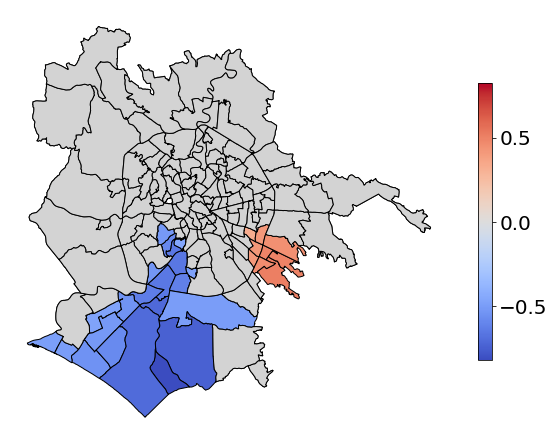

pop_density


/tmp/ipykernel_7241/2727747234.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[gwr_filtered_t.loc[:, col] == 0] = np.nan
/tmp/ipykernel_7241/2727747234.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[gwr_filtered_t.loc[:, col] == 0] = np.nan


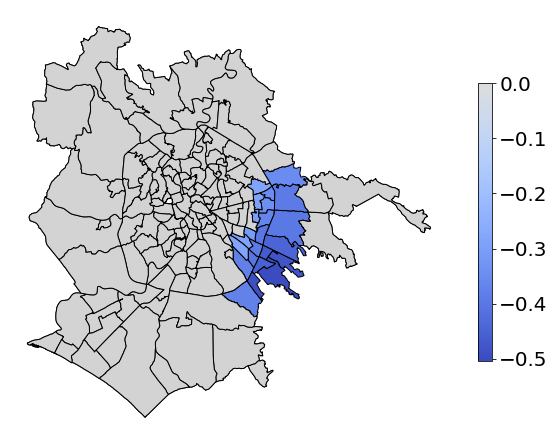

primary_roads_density


/tmp/ipykernel_7241/2727747234.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[gwr_filtered_t.loc[:, col] == 0] = np.nan
/tmp/ipykernel_7241/2727747234.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[gwr_filtered_t.loc[:, col] == 0] = np.nan


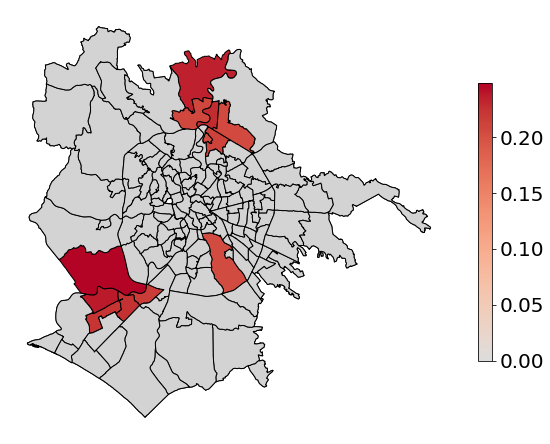

perc_roads_bc


/tmp/ipykernel_7241/2727747234.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[gwr_filtered_t.loc[:, col] == 0] = np.nan
/tmp/ipykernel_7241/2727747234.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[gwr_filtered_t.loc[:, col] == 0] = np.nan


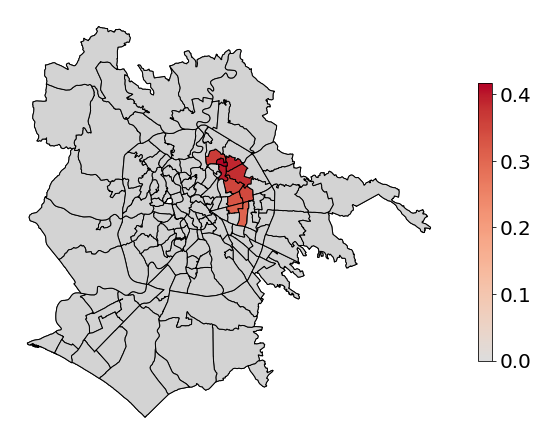

In [61]:
FIT_INTERCEPT=False

# bandwidth selection
gwr_chosen_selector = mgwr.sel_bw.Sel_BW(coords, y_transformed, X_transformed, 
                                         fixed=False, spherical=True, multi=False, 
                                         kernel='gaussian')
gwr_bw = gwr_chosen_selector.search(verbose=False)

# fitting GWR
gwr_model = mgwr.gwr.GWR(
    coords, y_transformed, X_transformed, gwr_bw, constant=FIT_INTERCEPT
)
gwr_results = gwr_model.fit()

# features importance in each area
gwr_columns = X.columns
if FIT_INTERCEPT:
    gwr_columns = gwr_columns.insert(0, "Intercept")
coefs_gwr = pd.DataFrame(gwr_results.params, columns=gwr_columns)

medians_gwr = coefs_gwr.median()
medians_gwr = medians_gwr.reindex(medians_gwr.abs().sort_values(ascending=False).index)
coefs_gwr = coefs_gwr[medians_gwr.index]
limit_value = (
    max(abs(coefs_gwr.to_numpy().min()), abs(coefs_gwr.to_numpy().max())) * 1.05
)

plot_maps_feature_coefs_in_each_area(gdf_rome_connected, gwr_results, gwr_columns, coefs_gwr, 
                                         sim_name='all_vehicles', FIT_INTERCEPT=FIT_INTERCEPT, SAVE_FIG=SAVE_FIG)

#'''
map__scenario__median_coeffs = {'all_vehicles' : medians_gwr}
for sim_scenario_name in map__scenario__filename.keys():
    
    # loading emissions in the scenario
    gdf_rome_sim = gpd.read_file(PATH_TO_PROCESSED_FILES / map__scenario__filename[sim_scenario_name])
    gdf_rome_sim.drop(columns=["geometry",'area_code','SHAPE_Leng','SHAPE_Area'])
    gdf_rome_connected_sim = gdf_rome_sim.drop(index=[97])
    y_sim = gdf_rome_connected_sim[feature_to_predict]
    
    ## transforming y_sim
    pwt = PowerTransformer()
    pwt.fit(y_sim.values.reshape(-1, 1))
    y_transformed_sim = pwt.transform(y_sim.values.reshape(-1, 1))
    
    ### model with y_sim
    # bandwidth selection
    gwr_chosen_selector_sim = mgwr.sel_bw.Sel_BW(coords, y_transformed_sim, X_transformed, 
                                             fixed=False, spherical=True, multi=False, 
                                             kernel='gaussian')
    gwr_bw_sim = gwr_chosen_selector_sim.search(verbose=False)

    # fitting GWR
    gwr_model_sim = mgwr.gwr.GWR(
        coords, y_transformed_sim, X_transformed, gwr_bw_sim, constant=FIT_INTERCEPT
    )
    gwr_results_sim = gwr_model_sim.fit()

    # features importance in each area
    gwr_columns_sim = X.columns
    if FIT_INTERCEPT:
        gwr_columns_sim = gwr_columns_sim.insert(0, "Intercept")
    coefs_gwr_sim = pd.DataFrame(gwr_results_sim.params, columns=gwr_columns_sim)

    medians_gwr_sim = coefs_gwr_sim.median()
    medians_gwr_sim = medians_gwr_sim.reindex(medians_gwr_sim.abs().sort_values(ascending=False).index)
    coefs_gwr_sim = coefs_gwr_sim[medians_gwr_sim.index]
    limit_value = (
        max(abs(coefs_gwr_sim.to_numpy().min()), abs(coefs_gwr_sim.to_numpy().max())) * 1.05
    )
    
    map__scenario__median_coeffs[sim_scenario_name] = medians_gwr_sim
    
    
    plot_maps_feature_coefs_in_each_area(gdf_rome_connected, gwr_results_sim, gwr_columns_sim, coefs_gwr_sim, 
                                         sim_name=sim_scenario_name, FIT_INTERCEPT=FIT_INTERCEPT, SAVE_FIG=SAVE_FIG)

df_medians = pd.DataFrame.from_dict(map__scenario__median_coeffs)
#df_medians
#'''

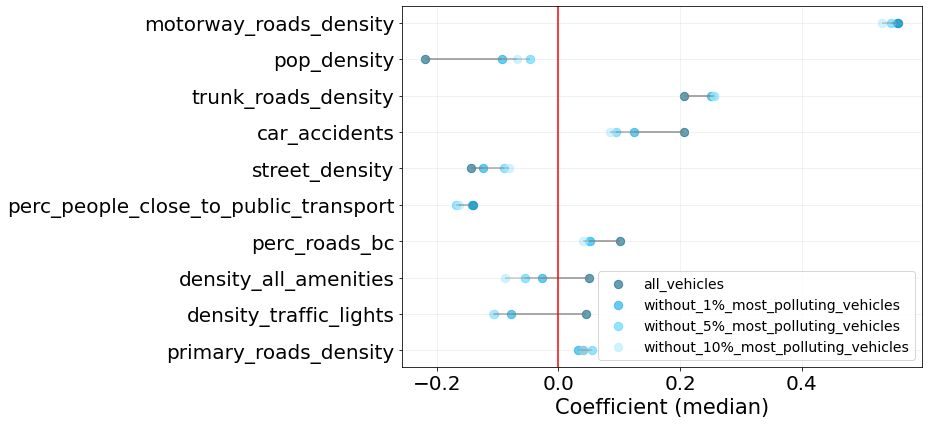

In [65]:
fig, ax = plt.subplots(figsize=(13,6))

#df_medians = pd.concat([medians_all, medians_all_sim], axis=1)
#df_medians.columns = ['all_vehicles', scenario_to_simulate]

# Reorder it following the values of the first value:
ordered_df = df_medians.sort_values(by='all_vehicles', key=abs)
my_range=range(1,len(df_medians.index)+1)

map__scenario__color = {
    'all_vehicles' : '#006080',
    'without_1%_most_polluting_vehicles' : '#00ace6',
    'without_5%_most_polluting_vehicles' : '#4dd2ff',
    'without_10%_most_polluting_vehicles' : '#b3ecff'
}

# The horizontal plot is made using the hline function
for scenario_name in ordered_df.columns:
    ax.hlines(y=my_range, xmin=ordered_df['all_vehicles'], xmax=ordered_df[scenario_name], color='grey', alpha=0.4)
    ax.scatter(ordered_df[scenario_name], my_range, s=70, color=map__scenario__color[scenario_name], marker='o', alpha=0.6, label=scenario_name)
#plt.scatter(ordered_df['all_vehicles'], my_range, s=60, color='#00b3b3', marker='o', alpha=1, label='all_vehicles')
#plt.scatter(ordered_df[scenario_to_simulate], my_range, s=60, color='lightblue', alpha=1, marker='o', label=scenario_to_simulate)
plt.axvline(x=0, color="red")
plt.legend(loc='best', fontsize=14)
 
# Add title and axis names
plt.yticks(my_range, ordered_df.index)
ax.tick_params(axis='both', which='major', labelsize=axis_ticklabel_fontsize)
ax.set_xlabel("Coefficient (median)", fontsize=axis_label_fontsize)
plt.grid(alpha=0.2)
plt.tight_layout()

if SAVE_FIG:
    plt.savefig(PATH_TO_OUTPUT / 'sensitivity_GWR__scatter__simulation_ALLperc.pdf', format='pdf')
    plt.savefig(PATH_TO_OUTPUT / 'sensitivity_GWR__scatter__simulation_ALLperc.png', format='png', dpi=300)

# Show the graph
plt.show()

Coefficients are very similar to those obtained with LR.